## CIFAKE Dataset

In [ ]:
!wget https://www.inf.ufpr.br/acgbas19/cifake-dataset.zip
!unzip -d cifake-dataset cifake-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: cifake-dataset/train/REAL/4500 (10).jpg  
  inflating: cifake-dataset/train/REAL/4500 (2).jpg  
  inflating: cifake-dataset/train/REAL/4500 (3).jpg  
  inflating: cifake-dataset/train/REAL/4500 (4).jpg  
  inflating: cifake-dataset/train/REAL/4500 (5).jpg  
  inflating: cifake-dataset/train/REAL/4500 (6).jpg  
  inflating: cifake-dataset/train/REAL/4500 (7).jpg  
  inflating: cifake-dataset/train/REAL/4500 (8).jpg  
  inflating: cifake-dataset/train/REAL/4500 (9).jpg  
  inflating: cifake-dataset/train/REAL/4500.jpg  
  inflating: cifake-dataset/train/REAL/4501 (10).jpg  
  inflating: cifake-dataset/train/REAL/4501 (2).jpg  
  inflating: cifake-dataset/train/REAL/4501 (3).jpg  
  inflating: cifake-dataset/train/REAL/4501 (4).jpg  
  inflating: cifake-dataset/train/REAL/4501 (5).jpg  
  inflating: cifake-dataset/train/REAL/4501 (6).jpg  
  inflating: cifake-dataset/train/REAL/4501 (7).jpg  
  inflating: cifake-dataset/train

## Módulos

In [ ]:
import cv2
import glob
import numpy as np
import os
import tensorflow as tf

from sklearn.model_selection import train_test_split

## Conjuntos de treinamento e de validação (Train set | Validation Set)

In [ ]:
dataset_dir = "./cifake-dataset/"
trainset_dir = dataset_dir + "train/"
testset_dir = dataset_dir + "test/"

X = []
y = []

for filename in glob.glob(trainset_dir + "**/*.jpg"):
  img = cv2.imread(filename)
  X.append(img)
  if "FAKE" in filename:
    y.append(0)
  else:
    y.append(1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array(X_train)/255
y_train = np.array(y_train)

X_val = np.array(X_val)/255
y_val = np.array(y_val)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((80000, 32, 32, 3), (80000,), (20000, 32, 32, 3), (20000,))

In [ ]:
X_train[0], y_train[0]

(array([[[0.08627451, 0.08235294, 0.09019608],
         [0.09019608, 0.08627451, 0.09411765],
         [0.05882353, 0.05490196, 0.0627451 ],
         ...,
         [0.88235294, 0.87843137, 0.88627451],
         [0.89411765, 0.89019608, 0.89803922],
         [0.8       , 0.79607843, 0.80392157]],
 
        [[0.08235294, 0.07843137, 0.08627451],
         [0.09019608, 0.08627451, 0.09411765],
         [0.0627451 , 0.05882353, 0.06666667],
         ...,
         [0.83137255, 0.82745098, 0.83529412],
         [0.87843137, 0.8745098 , 0.88235294],
         [0.82352941, 0.81960784, 0.82745098]],
 
        [[0.07843137, 0.0745098 , 0.08235294],
         [0.09019608, 0.08627451, 0.09411765],
         [0.06666667, 0.0627451 , 0.07058824],
         ...,
         [0.8       , 0.79607843, 0.80392157],
         [0.8745098 , 0.87058824, 0.87843137],
         [0.85098039, 0.84705882, 0.85490196]],
 
        ...,
 
        [[0.43137255, 0.42745098, 0.43529412],
         [0.40392157, 0.4       , 0.40784

## Conjunto de teste (Test set)

In [ ]:
X = []
y = []

for filename in glob.glob(testset_dir + "**/*.jpg"):
  img = cv2.imread(filename)
  X.append(img)
  if "FAKE" in filename:
    y.append(0)
  else:
    y.append(1)

X_test = np.array(X)/255
y_test = np.array(y)

In [ ]:
X_test.shape, y_test.shape

((20000, 32, 32, 3), (20000,))

## Importing **"keras"** for CNN

In [ ]:
from tensorflow.keras import models , layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

ef_model = VGG16(input_shape=(32, 32, 3), include_top=False, weights='imagenet')

model = Sequential()
model.add(ef_model)
model.add(Flatten())
# model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 14,715,714
Trainable params: 14,715,714
Non-trainable params: 0
_________________________________________________________________


In [ ]:
MODEL_OUTPUT_DIR = './vgg16-model/'
!rm -rf vgg16-model
!mkdir -p vgg16-model

trainning_patience = 5
num_epochs = 50

checkpoint_filepath = os.path.join(MODEL_OUTPUT_DIR, 'models', '{0}_model.{1}-{2}.h5'.format('vgg16', '{epoch:02d}', '{val_loss:.7f}'))
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=trainning_patience, verbose=1)
callbacks=[csv_callback, checkpoint_callback, early_stopping_callback]

model.compile(
    optimizer = 'adam',
    loss= 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=num_epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
2500/2500 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.8531
Epoch 1: val_loss improved from inf to 0.22335, saving model to ./vgg16-model/models/vgg16_model.01-0.2233485.h5
2500/2500 [==============================] - 88s 29ms/step - loss: 0.3380 - accuracy: 0.8531 - val_loss: 0.2233 - val_accuracy: 0.9097
Epoch 2/50
2499/2500 [============================>.] - ETA: 0s - loss: 0.2291 - accuracy: 0.9089
Epoch 2: val_loss improved from 0.22335 to 0.19982, saving model to ./vgg16-model/models/vgg16_model.02-0.1998219.h5
2500/2500 [==============================] - 80s 32ms/step - loss: 0.2291 - accuracy: 0.9089 - val_loss: 0.1998 - val_accuracy: 0.9222
Epoch 3/50
2500/2500 [==============================] - ETA: 0s - loss: 0.8860 - accuracy: 0.8671
Epoch 3: val_loss did not improve from 0.19982
2500/2500 [==============================] - 72s 29ms/step - loss: 0.8860 - accuracy: 0.8671 - val_loss: 0.4701 - val_accuracy: 0.7691
Epoch 4/50
2499/2500 [==

In [ ]:
from tensorflow.keras.models import load_model

models = glob.glob('./vgg16-model/models/*.h5')
best_model = max(models, key=os.path.getctime)
MODEL_PATH = best_model
print('Using model {0} for testing.'.format(MODEL_PATH))
model = load_model(MODEL_PATH)

Using model ./vgg16-model/models/vgg16_model.16-0.1246641.h5 for testing.


In [ ]:
model.evaluate(X_test, y_test)

625/625 [==============================] - 5s 8ms/step - loss: 0.1296 - accuracy: 0.9509


[0.12964525818824768, 0.9509000182151794]

In [ ]:
y_pred = model.predict(X_test)

625/625 [==============================] - 4s 7ms/step


In [ ]:
y_pred_label = [np.argmax(i) for i in y_pred]
y_pred_label[:5]

[1, 1, 1, 1, 1]

## Classification Report

In [ ]:
from sklearn.metrics import classification_report

print('Classification Report     : \n\n\n' , classification_report(y_test, y_pred_label))

Classification Report     : 


               precision    recall  f1-score   support

           0       0.95      0.95      0.95     10000
           1       0.95      0.95      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_label)

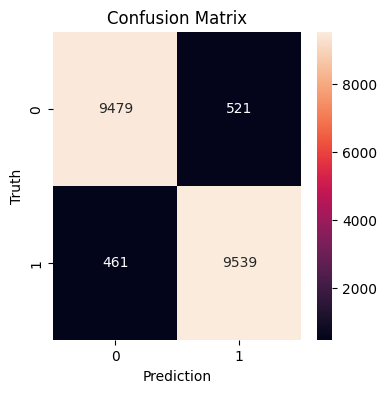

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn


plt.figure(figsize=(4,4), facecolor= 'white', edgecolor='brown')
sn.heatmap(cm , annot= True, fmt="d")
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()